宏观数据下载地址为：链接: https://pan.baidu.com/s/1-bUK1_ek3ZFBbIWL-RYtHA 提取码: 6xij
下载后将数据与代码放在研究环境中Macro文件夹中即可运行。

In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/16184
# 标题：股票指数的宏观择时

from jqdata import *
import numpy as np
import pandas as pd
import datetime as dt
from six import StringIO
from dateutil.parser import parse
import cPickle as pickle
import seaborn as sns
import matplotlib as mpl
import os
import statsmodels.api as sm
import scipy
import talib as tl


mpl.rcParams['font.family']='serif'
mpl.rcParams['axes.unicode_minus']=False # 处理负号

load_data={}

path = '/home/jquser/Macro'

class backtest_result():
    def __init__(self,data):
        self.data = data
        self.total_returns = data.iloc[-1]-1
        self.annualized_returns = data.iloc[-1]**(12./len(data))-1
        self.annualized_volatility = data.pct_change().std()*(12.**0.5)
    def Max_Drawback(self):
        net_value=self.data
        max_value=0
        df_tmp=pd.DataFrame(net_value)
        df_tmp.columns=['value']
        for j in range(0,len(net_value),1):
            max_value=max(max_value,df_tmp.ix[j,'value'])
            df_tmp.ix[j,'drawback']=1-df_tmp.ix[j,'value']/max_value
            drawback=df_tmp['drawback'].max()
        return drawback
    def Sharpe(self):
        net_value=self.data
        bench_pct=0.03
        df_tmp=pd.DataFrame(net_value)
        df_tmp.columns=['value']
        df_tmp['pct']=df_tmp['value'].pct_change()
        annual_pct = df_tmp.ix[-1,'value']**(12./len(df_tmp))-1
        sharpe = (annual_pct-bench_pct)/(df_tmp['pct'].std()*12**0.5)
        return sharpe
    def Calmar(self):
        clamar = self.annualized_returns/self.Max_Drawback()
        return clamar

Index([u'日期', u'PMI', u'PMI:生产', u'PMI:新订单', u'PMI:新出口订单', u'PMI:进口'], dtype='object')


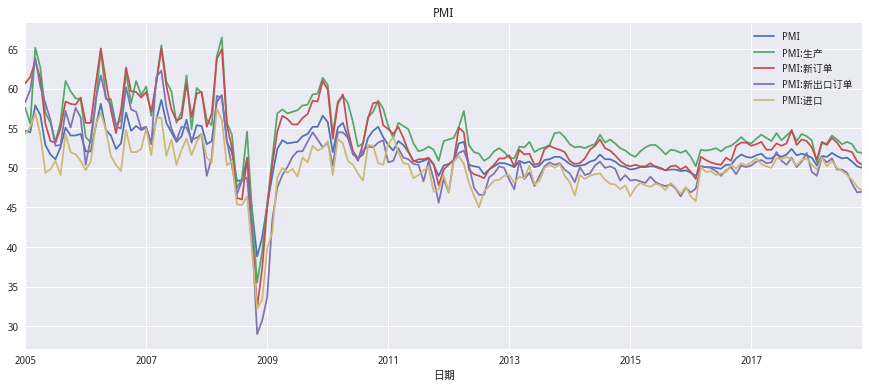

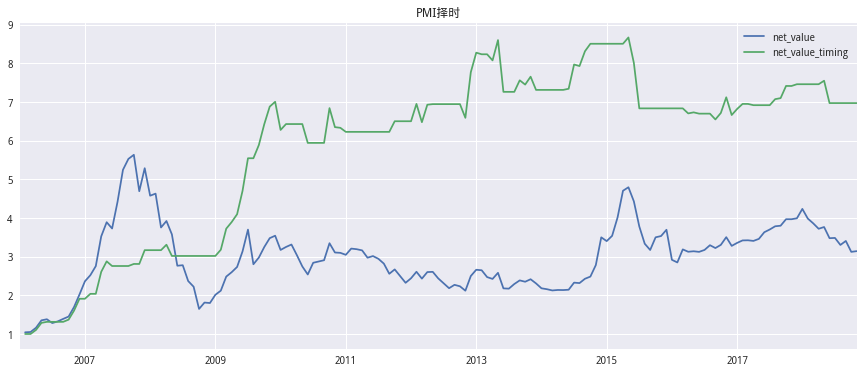

In [2]:
#PMI择时
body=read_file(path+'/PMI组合.xls')
df_boom=pd.read_excel(StringIO(body))
print df_boom.columns
col =u'PMI'
df_boom=df_boom.set_index(u'日期')
df_boom.plot(figsize=(15,6),title='PMI')
n=3
df_boom['position']=(pd.rolling_mean(df_boom[col],n).shift(1)>pd.rolling_mean(df_boom[col],n).shift(2))*1.
prices = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')['close']
prices_M = prices.resample('M',how='last')
rate_riskfree = 0
df_pct=pd.DataFrame()
df_pct['pct']=prices_M.pct_change()
df_pct['position']=df_boom['position']
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='PMI择时')


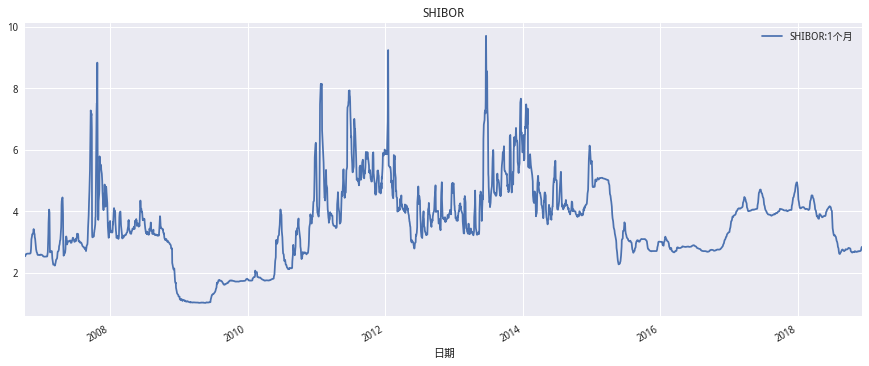

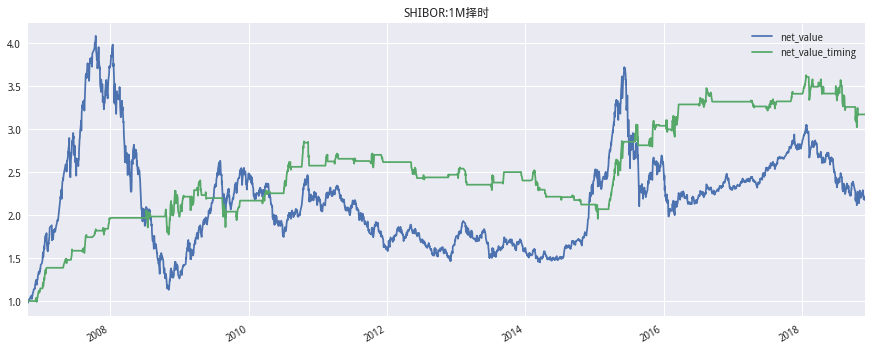

In [3]:
#利率择时
body=read_file(path+'/SHIBOR数据.xls')
df_interest=pd.read_excel(StringIO(body))
col = u'SHIBOR:1个月'
df_interest=df_interest.set_index(u'日期')

df_interest.iloc[:,1:2].plot(figsize=(15,6),title='SHIBOR')
df_interest=df_interest[[col]]
upperband,middleband,lowerband = (tl.BBANDS(df_interest[col].values, timeperiod=12, nbdevup=1.8, nbdevdn=1.8))
# print df_1

df_interest['BBAND_upper']=upperband
df_interest['BBAND_middle']=middleband
df_interest['BBAND_lower']=lowerband

pre_position = 0
for date in df_interest.index:
    if df_interest.loc[date,col]>df_interest.loc[date,'BBAND_middle']:
        df_interest.loc[date,'position']=0
    elif df_interest.loc[date,col]<df_interest.loc[date,'BBAND_lower']:
        df_interest.loc[date,'position']=1.0
    else:
        df_interest.loc[date,'position']=pre_position
    pre_position=df_interest.loc[date,'position']
df_interest['position']=df_interest['position'].shift(1)

df_pct=pd.DataFrame()
prices = get_price('000300.XSHG',start_date='2005-01-01',end_date='2018-11-30',fields='close')['close']
df_pct['pct']=prices.pct_change()

rate_riskfree = 0
df_pct = pd.concat([df_pct,df_interest],axis=1)['2006-01-01':'2018-11-30'].dropna()
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='SHIBOR:1M择时')
# df_pct
# df_1['2007-01-01':'2018-11-30'].iloc[:1000].plot(figsize=(15,10))
# print backtest_result(df_pct['net_value_timing']).Sharpe()

Index([u'中债国债到期收益率:1个月', u'中债国债到期收益率:3个月', u'中债国债到期收益率:6个月',  u'中债国债到期收益率:3年',
        u'中债国债到期收益率:5年', u'中债国债到期收益率:10年'],
      dtype='object')


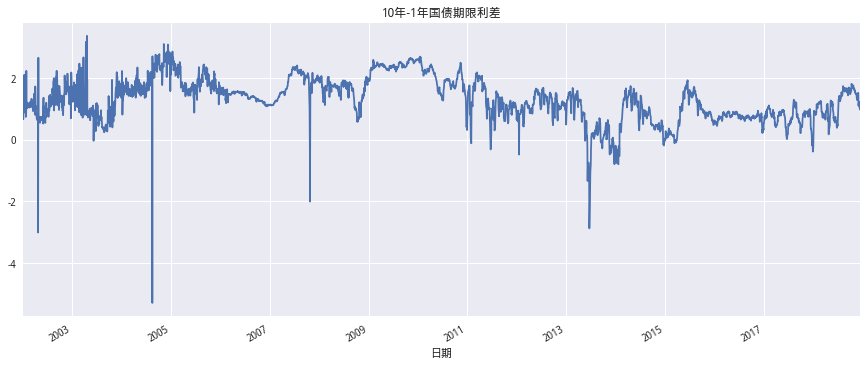

In [4]:
#获取国债期限利差数据
body=read_file(path+'/国债到期收益率.xls')
df_gz=pd.read_excel(StringIO(body))
df_gz.set_index(u'日期',inplace=True)
print df_gz.columns
df_gz=df_gz.fillna(method='ffill')
term_spread_gz = df_gz[u'中债国债到期收益率:10年']-df_gz[u'中债国债到期收益率:1个月']
term_spread_gz_diff = term_spread_gz.diff(21)
term_spread_gz=pd.rolling_mean(term_spread_gz,1)
term_spread_gz.plot(figsize=(15,6),title='10年-1年国债期限利差')

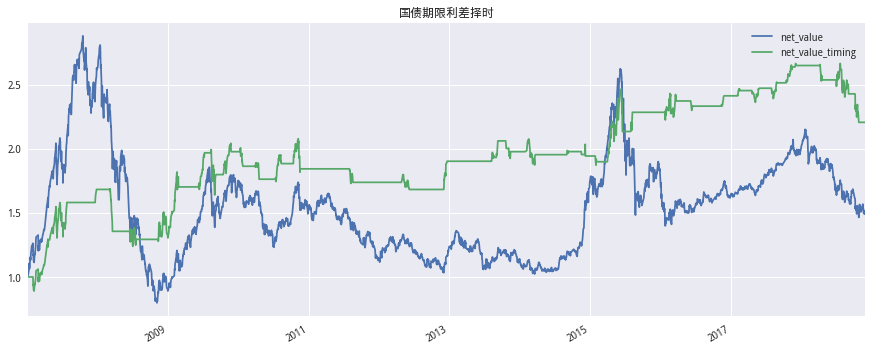

In [5]:
#期限利差择时
df_termspread=pd.DataFrame()
col='termspread'
df_termspread=term_spread_gz.to_frame('termspread')
upperband,middleband,lowerband = (tl.BBANDS(df_termspread[col].values, timeperiod=25, nbdevup=1.8, nbdevdn=1.8))
# print df_termspread

df_termspread['BBAND_upper']=upperband
df_termspread['BBAND_middle']=middleband
df_termspread['BBAND_lower']=lowerband
# df_termspread
df_termspread.head()
pre_position = 0
for date in df_termspread.index:
    if df_termspread.loc[date,col]<df_termspread.loc[date,'BBAND_middle']:
        df_termspread.loc[date,'position']=0
    elif df_termspread.loc[date,col]>df_termspread.loc[date,'BBAND_upper']:
        df_termspread.loc[date,'position']=1.0
    else:
        df_termspread.loc[date,'position']=pre_position
    pre_position=df_termspread.loc[date,'position']
df_termspread['position']=df_termspread['position'].shift(1)
df_termspread.head().append(df_termspread.tail())

df_pct=pd.DataFrame()
prices = get_price('000300.XSHG',start_date='2005-01-01',end_date='2018-11-30',fields='close')['close']
df_pct['pct']=prices.pct_change()

rate_riskfree = 0
df_pct = pd.concat([df_pct,df_termspread],axis=1)['2007-01-01':'2018-11-30'].dropna()
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='国债期限利差择时')

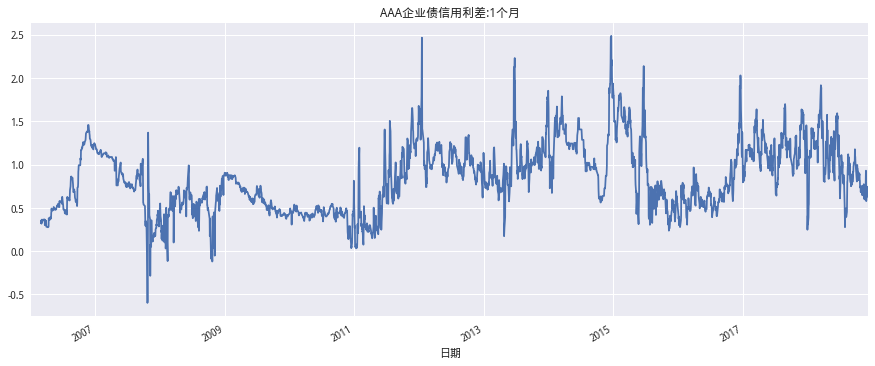

In [6]:
#获取信用利差数据
body=read_file(path+'/企业债到期收益率(AAA).xls')
df_qyz=pd.read_excel(StringIO(body))
df_qyz.set_index(u'日期',inplace=True)
df_qyz=df_qyz.fillna(method='ffill')

credit_spread = df_qyz[u'中债企业债到期收益率(AAA):1个月']-df_gz[u'中债国债到期收益率:1个月']

credit_spread=pd.rolling_mean(credit_spread,1)
credit_spread['2006-01-01':].plot(figsize=(15,6),title='AAA企业债信用利差:1个月')

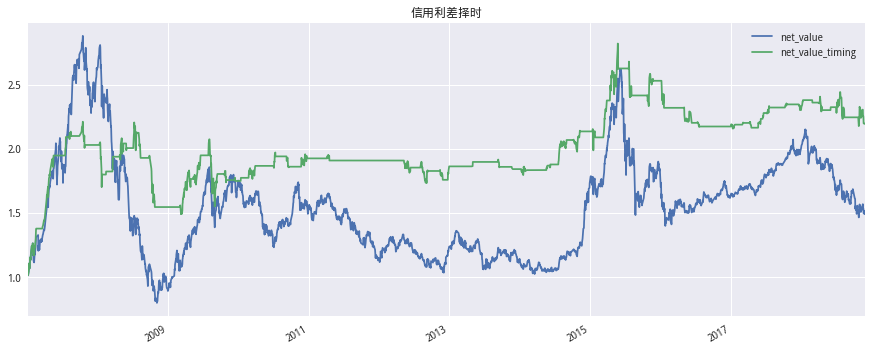

In [7]:
#信用利差择时
df_creditspread=pd.DataFrame()
col='creditspread'
df_creditspread=credit_spread.to_frame('creditspread')
upperband,middleband,lowerband = (tl.BBANDS(df_creditspread[col].values, timeperiod=25, nbdevup=1.8, nbdevdn=1.8))

df_creditspread['BBAND_upper']=upperband
df_creditspread['BBAND_middle']=middleband
df_creditspread['BBAND_lower']=lowerband
pre_position = 0
for date in df_creditspread.index:
    if df_creditspread.loc[date,col]>df_creditspread.loc[date,'BBAND_middle']:
        df_creditspread.loc[date,'position']=0
    elif df_creditspread.loc[date,col]<df_creditspread.loc[date,'BBAND_lower']:
        df_creditspread.loc[date,'position']=1.0
    else:
        df_creditspread.loc[date,'position']=pre_position
    pre_position=df_creditspread.loc[date,'position']
df_creditspread['position']=df_creditspread['position'].shift(1)

df_pct=pd.DataFrame()
prices = get_price('000300.XSHG',start_date='2005-01-01',end_date='2018-11-30',fields='close')['close']
df_pct['pct']=prices.pct_change()

rate_riskfree =0
df_pct = pd.concat([df_pct,df_creditspread],axis=1)['2007-01-01':'2018-11-30'].dropna()
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='信用利差择时')

Index([u'社会融资规模:当月值', u'M1:同比', u'M2:同比'], dtype='object')


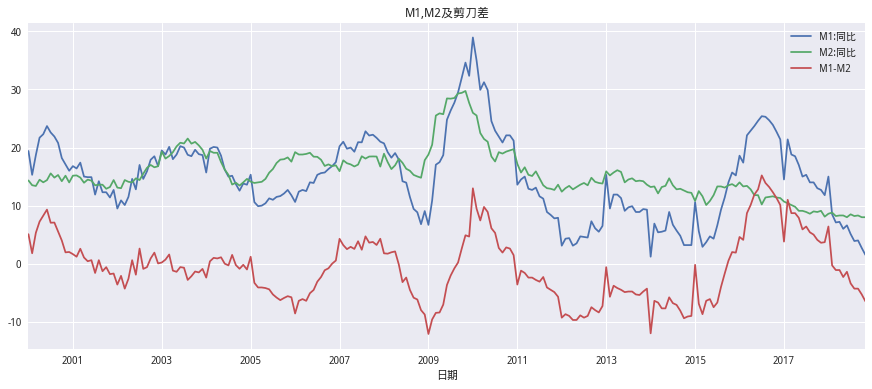

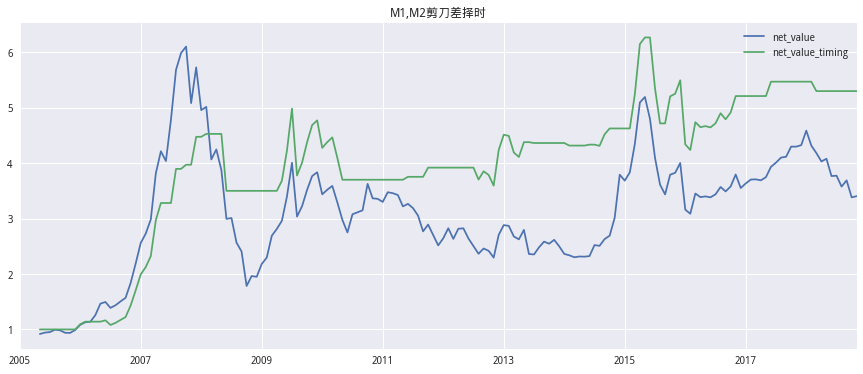

In [8]:
#M1,M2剪刀差择时
body=read_file(path+'/信贷.xls')
df_credit_loan_1=pd.read_excel(StringIO(body))
df_credit_loan_1=df_credit_loan_1.set_index(u'日期')
print df_credit_loan_1.columns
col = u'社会融资规模:当月值'
col_1 = u'M1:同比'
col_2 = u'M2:同比'
# col = col_1
col = u'M1-M2'
df_credit_loan_1[u'M1-M2'] = df_credit_loan_1[u'M1:同比']-df_credit_loan_1[u'M2:同比']
n=3
df_credit_loan_1.iloc[:,1:].plot(figsize=(15,6),title='M1,M2及剪刀差')
df_credit_loan_1['position']=pd.rolling_mean(df_credit_loan_1[col],n).shift(2)>pd.rolling_mean(df_credit_loan_1[col],n).shift(3)
prices = get_price('000300.XSHG',start_date='2005-01-01',end_date='2018-11-30',fields='close')['close']
prices_M = prices.resample('M',how='last')

rate_riskfree = 0#(1+1.25e-4)**21.0-1

df_pct=pd.DataFrame()
df_pct['pct']=prices_M.pct_change()
df_pct['position']=df_credit_loan_1['position']
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='M1,M2剪刀差择时')

Index([u'社会融资规模:当月值', u'M1:同比', u'M2:同比'], dtype='object')


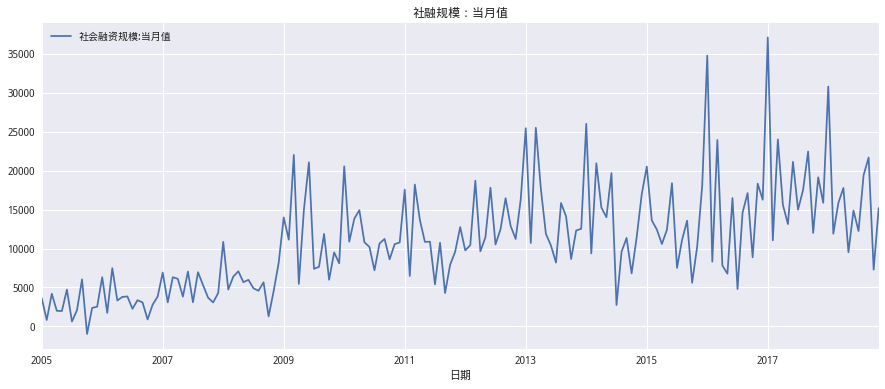

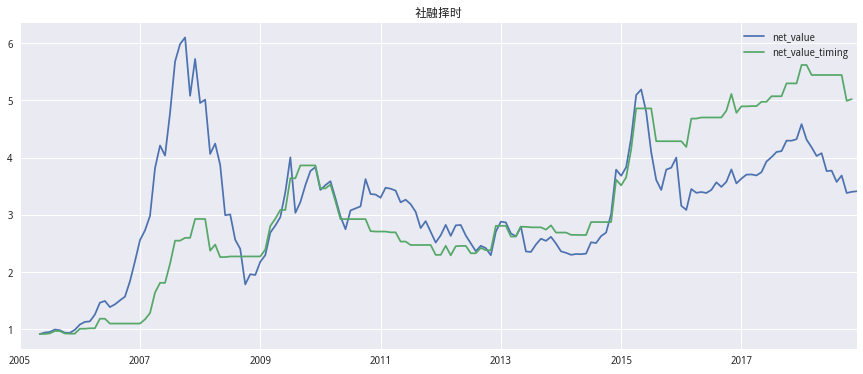

In [9]:
#社融择时
body=read_file(path+'/信贷.xls')
df_credit_loan_2=pd.read_excel(StringIO(body))
df_credit_loan_2=df_credit_loan_2.set_index(u'日期')
print df_credit_loan_2.columns
col = u'社会融资规模:当月值'
col_1 = u'M1:同比'
col_2 = u'M2:同比'
n=3
pd.rolling_mean(df_credit_loan_2.iloc[:,:1],1)['2005-01-01':].plot(figsize=(15,6),title='社融规模：当月值')
df_credit_loan_2['position']=pd.rolling_mean(df_credit_loan_2[col],n).shift(2)>pd.rolling_mean(df_credit_loan_2[col],n).shift(3)
prices = get_price('000300.XSHG',start_date='2005-01-01',end_date='2018-12-07',fields='close')['close']
prices_M = prices.resample('M',how='last')

rate_riskfree = 0#(1+1.25e-4)**21.0-1

df_pct=pd.DataFrame()
df_pct['pct']=prices_M.pct_change()
df_pct['position']=df_credit_loan_2['position']
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='社融择时')

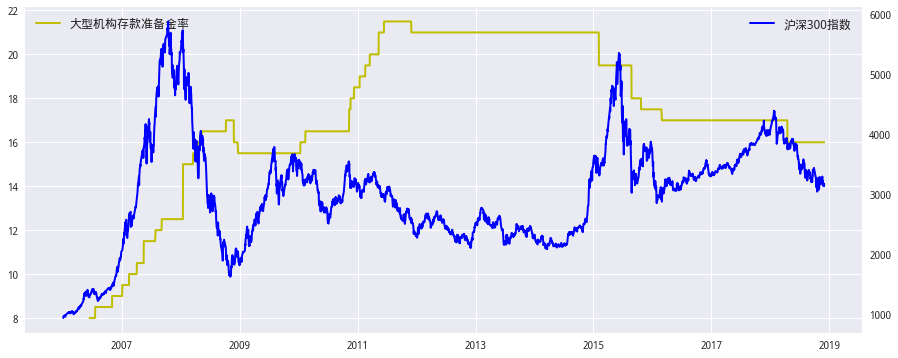

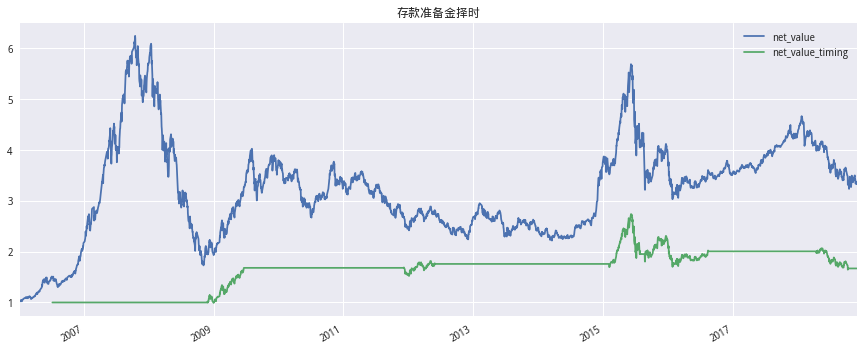

In [10]:
#存款准备金择时
body=read_file(path+'/存款准备金率-大型存款类机构.xls')
df_reserves=pd.read_excel(StringIO(body))
df_reserves = df_reserves.set_index(u'日期')
df_reserves
col=u'人民币存款准备金率:大型存款类金融机构'
df_pct=pd.DataFrame()
prices = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')['close']
prices_M = prices.resample('M',how='last')
df_pct['pct']=prices.pct_change()
df_pct
rate_riskfree=0
# df_reserves['position']=df_reservesdf_reserves
df_reserves=df_reserves.reindex(prices.index).fillna(method='ffill')
# df_reserves[col].plot(figsize=(15,6))
# df_reserves['position'].plot(figsize=(15,6))
fig = plt.figure(figsize=(15,6))
# fig = plt.grid(False)
ax1=fig.add_subplot(111)
ax1.plot(df_reserves[col],'y-',linewidth=2,label='大型机构存款准备金率')
ax1.legend(loc=2,fontsize=12)
ax2=ax1.twinx()#这是双坐标关键一步
ax2.plot(prices,'b-',linewidth=2,label='沪深300指数')
ax2.legend(loc=1,fontsize=12)
# ax1.grid(False)
ax2.grid(False)
plt.show()

pre_position=0
delay_days=120
for i in range(delay_days,len(df_reserves)):
    pre_index = df_reserves.index[i-delay_days]
    index = df_reserves.index[i]
#     print df_reserves.loc[index,col]
    if df_reserves.loc[index,col]<df_reserves.loc[pre_index,col]:
        df_reserves.loc[index,'position']=1
    elif df_reserves.loc[index,col]>df_reserves.loc[pre_index,col]:
        df_reserves.loc[index,'position']=0.
    else:
        df_reserves.loc[index,'position']=0.
    pre_position = df_reserves.loc[index,'position']
df_pct['position'] = df_reserves['position']
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='存款准备金择时')

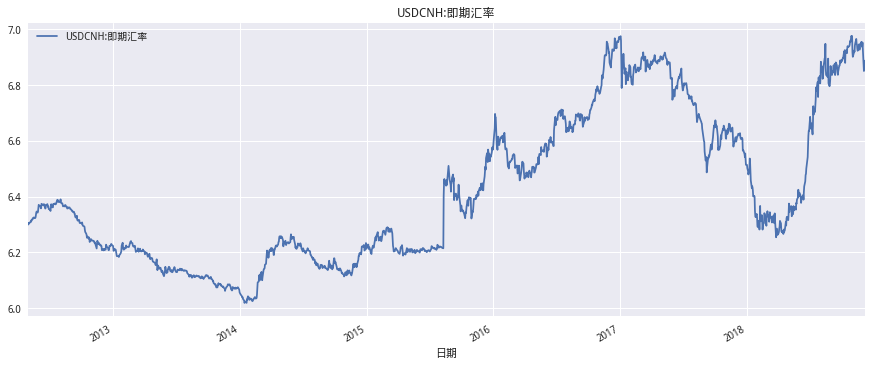

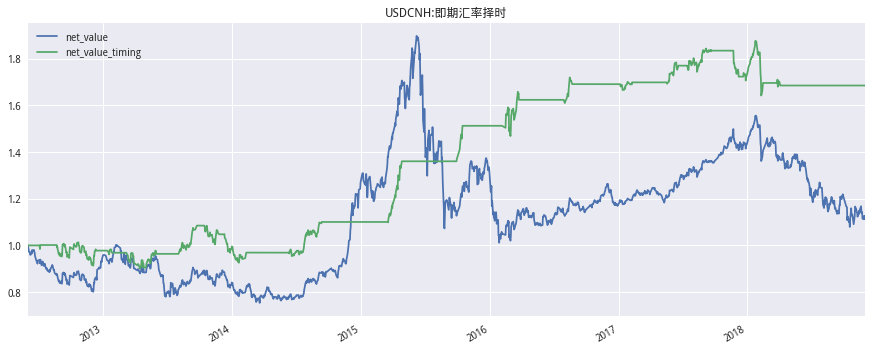

In [11]:
#USDCNH:即期汇率择时
body=read_file(path+'/离岸汇率数据.xls')
df_exchange_rate=pd.read_excel(StringIO(body))
col = u'USDCNH:即期汇率'
df_exchange_rate=df_exchange_rate.set_index(u'日期')
df_exchange_rate.plot(figsize=(15,6),title='USDCNH:即期汇率')

upperband,middleband,lowerband = (tl.BBANDS(df_exchange_rate[col].values, timeperiod=25, nbdevup=1.8, nbdevdn=1.8))
df_exchange_rate['BBAND_upper']=upperband
df_exchange_rate['BBAND_middle']=middleband
df_exchange_rate['BBAND_lower']=lowerband
df_exchange_rate.head()
pre_position = 0
for date in df_exchange_rate.index:
    if df_exchange_rate.loc[date,col]>df_exchange_rate.loc[date,'BBAND_middle']:
        df_exchange_rate.loc[date,'position']=0
    elif df_exchange_rate.loc[date,col]<df_exchange_rate.loc[date,'BBAND_lower']:
        df_exchange_rate.loc[date,'position']=1.0
    else:
        df_exchange_rate.loc[date,'position']=pre_position
    pre_position=df_exchange_rate.loc[date,'position']
df_exchange_rate['position']=df_exchange_rate['position'].shift(1)
df_exchange_rate.head().append(df_exchange_rate.tail())

df_pct=pd.DataFrame()
prices = get_price('000300.XSHG',start_date='2005-01-01',end_date='2018-12-07',fields='close')['close']
df_pct['pct']=prices.pct_change()
df_pct = pd.concat([df_pct,df_exchange_rate],axis=1)['2007-01-01':'2018-11-30'].dropna()
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='USDCNH:即期汇率择时')

Index([u'日期', u'CPI:当月同比', u'预测平均值:CPI:当月同比', u'PPI:全部工业品:当月同比',
       u'预测平均值:PPI:当月同比'],
      dtype='object')


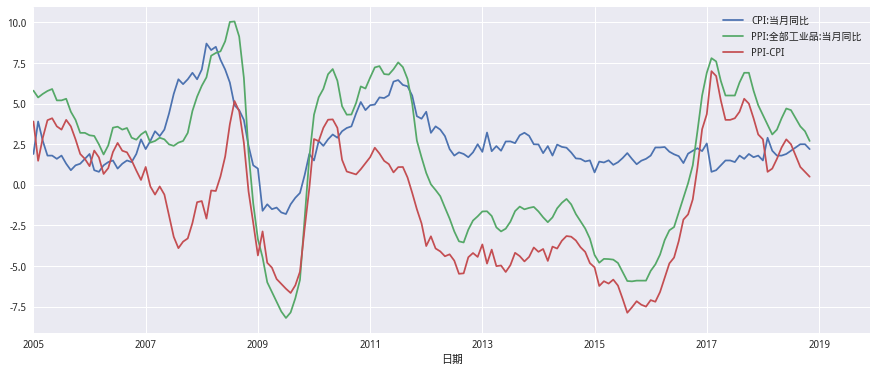

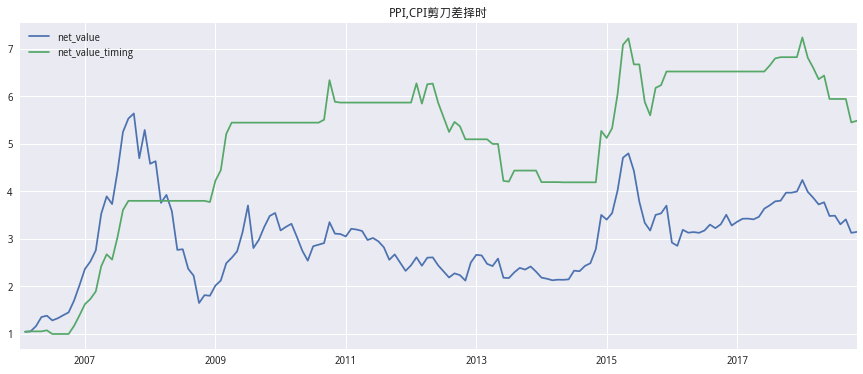

In [12]:
#通胀指数择时
body=read_file(path+'/CPI与PPI.xls')
df_inflation=pd.read_excel(StringIO(body))
print df_inflation.columns
col_0 =u'CPI:当月同比'
col_1 =u'PPI:全部工业品:当月同比'
df_inflation=df_inflation.set_index(u'日期')['2005-01-31':]
col_2 = u'PPI-CPI'
df_inflation[col_2] = -df_inflation[u'CPI:当月同比']+df_inflation[u'PPI:全部工业品:当月同比']
df_inflation[[col_0,col_1,col_2]].plot(figsize=(15,6))
def good_cpi(x):
    if x<0:
        y=0.
    elif x<5.:
        y=1.
    else:
        y=0
    return y
    
n=3
df_inflation['position']=(pd.rolling_mean(df_inflation[col_2],n).shift(2)<pd.rolling_mean(df_inflation[col_2],n).shift(3))*\
    (pd.rolling_mean(df_inflation[col_0],n).apply(good_cpi).shift(2))

prices = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')['close']
prices_M = prices.resample('M',how='last')
rate_riskfree = 0#(1+1.25e-4)**20.0-1
df_pct=pd.DataFrame()
df_pct['pct']=prices_M.pct_change()
df_pct['position']=df_inflation['position']
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='PPI,CPI剪刀差择时')

In [13]:
def dateRange(beginDate, endDate):
    dates = []
    dt=beginDate
    date = beginDate
    while date <= endDate:
        dates.append(date)
        dt = dt + datetime.timedelta(1)
        date = dt
    return dates
date_list = dateRange(prices_M.index[0],prices_M.index[-1])
len(date_list)

4687

0.155687136332
0.743063645005
0.15687538484


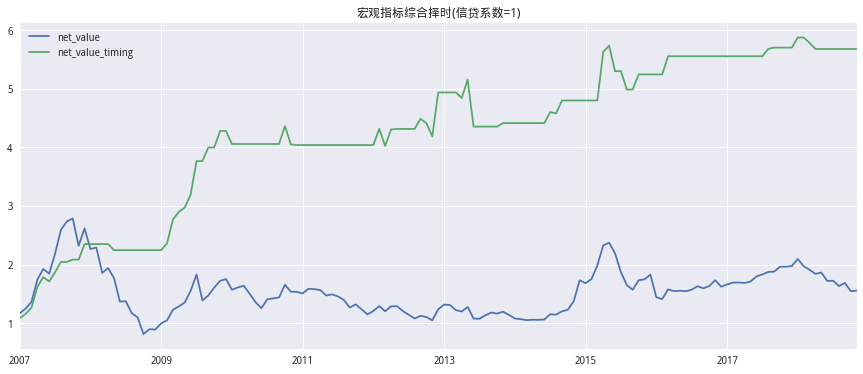

In [14]:
#汇总以上宏观指标
df_interest_M = df_interest['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#利率
df_termspread_M = df_termspread['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#期限利差
df_creditspread_M = df_creditspread['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#信用利差
df_monetray = ((df_interest_M*1 + df_termspread_M*1 + df_creditspread_M*1)/3.)*1
#货币政策择时指标=利率+期限利差+信用利差
df_forex = (df_exchange_rate['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1))
#汇率

df_credit_loan = ((df_credit_loan_1['position']*1+df_credit_loan_2['position']*1)/2.)*1
#信贷择时指标=M1,M2剪刀差+社融指标

df_month=pd.concat([df_monetray,df_forex,df_credit_loan,\
                  df_boom['position'],df_inflation['position']],axis=1)
factor_columns = ['monetary','forex','credit','boom','inflation']#货币政策，汇率，信贷，经济增长，通货膨胀
df_month.columns = factor_columns
weight_f=([1,1,1,1,1]) #五大类指标权重
timing_count=((df_month[factor_columns]>=0)*weight_f).sum(axis=1)
#每一期（月度）的满分（由于早期有些指标为NAN，因此满分不为1）
df_month['tot_pos'] = ((df_month[factor_columns]*weight_f).sum(axis=1)/timing_count>0.55)*0.5+\
    ((df_month[factor_columns]*weight_f).sum(axis=1)/timing_count>0.45)*0.5
#根据每一期得分占满分的比例做出仓位决策
prices = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')['close']
prices_M = prices.resample('M',how='last')
rate_riskfree = 0
df_pct=pd.DataFrame()
start_date='2007-01-01'
df_pct['pct']=prices_M.pct_change()[start_date:]
df_pct['position']=df_month['tot_pos']
df_pct['net_value'] =(df_pct['pct']+1)[start_date:].cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1)[start_date:].cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='宏观指标综合择时(信贷系数=1)')
print backtest_result(df_pct['net_value_timing']).Max_Drawback()#最大回撤
print backtest_result(df_pct['net_value_timing']).Sharpe()#夏普率
print backtest_result(df_pct['net_value_timing']).annualized_returns#年化收益

0.200432996889
0.818573247619
0.175762517663


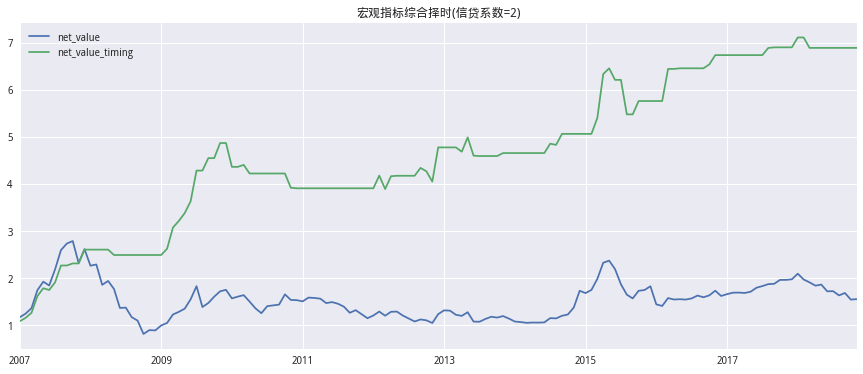

In [15]:
#汇总以上宏观指标
df_interest_M = df_interest['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#利率
df_termspread_M = df_termspread['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#期限利差
df_creditspread_M = df_creditspread['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#信用利差
df_monetray = ((df_interest_M*1 + df_termspread_M*1 + df_creditspread_M*1)/3.)*1
#货币政策择时指标=利率+期限利差+信用利差
df_forex = (df_exchange_rate['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1))
#汇率

df_credit_loan = ((df_credit_loan_1['position']*1+df_credit_loan_2['position']*1)/2.)*1
#信贷择时指标=M1,M2剪刀差+社融指标

df_month=pd.concat([df_monetray,df_forex,df_credit_loan,\
                  df_boom['position'],df_inflation['position']],axis=1)
factor_columns = ['monetary','forex','credit','boom','inflation']#货币政策，汇率，信贷，经济增长，通货膨胀
df_month.columns = factor_columns
weight_f=([1,1,2,1,1]) #五大类指标权重
timing_count=((df_month[factor_columns]>=0)*weight_f).sum(axis=1)
#每一期（月度）的满分（由于早期有些指标为NAN，因此满分不为1）
df_month['tot_pos'] = ((df_month[factor_columns]*weight_f).sum(axis=1)/timing_count>0.55)*0.5+\
    ((df_month[factor_columns]*weight_f).sum(axis=1)/timing_count>0.45)*0.5
#根据每一期得分占满分的比例做出仓位决策
prices = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')['close']
prices_M = prices.resample('M',how='last')
rate_riskfree = 0
df_pct=pd.DataFrame()
start_date='2007-01-01'
df_pct['pct']=prices_M.pct_change()[start_date:]
df_pct['position']=df_month['tot_pos']
df_pct['net_value'] =(df_pct['pct']+1)[start_date:].cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1)[start_date:].cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='宏观指标综合择时(信贷系数=2)')
print backtest_result(df_pct['net_value_timing']).Max_Drawback()#最大回撤
print backtest_result(df_pct['net_value_timing']).Sharpe()#夏普率
print backtest_result(df_pct['net_value_timing']).annualized_returns#年化收益

0.200432996889
0.859588035117
0.188686503713


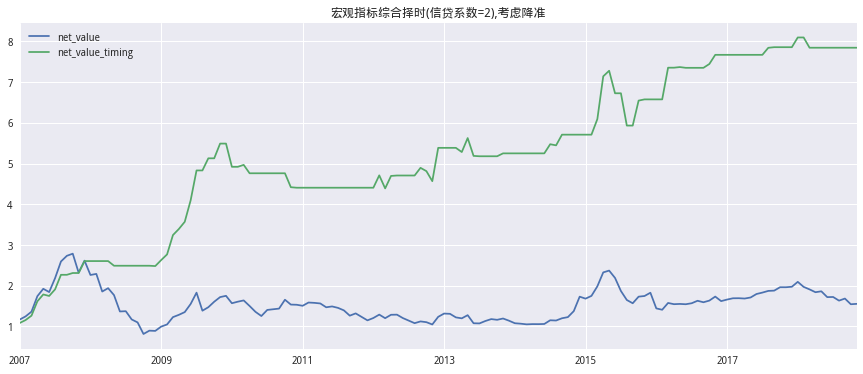

In [16]:
#汇总以上宏观指标
df_interest_M = df_interest['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#利率
df_termspread_M = df_termspread['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#期限利差
df_creditspread_M = df_creditspread['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#信用利差
df_reserves_M = df_reserves['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
df_monetray = ((df_interest_M*1 + df_termspread_M*1 + df_creditspread_M*1)/3.)*1

# df_monetray = ((df_interest_M*1 + df_termspread_M*1 + df_creditspread_M*1)/3.)*1 + df_reserves_M*0.33

df_monetray[df_monetray>1]=1

# df_monetray = ((df_interest_M*1 + df_termspread_M*1 + df_creditspread_M*1)/3.)*1
#货币政策择时指标=利率+期限利差+信用利差
df_forex = (df_exchange_rate['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1))
#汇率


df_credit_loan = ((df_credit_loan_1['position']*1+df_credit_loan_2['position']*1)/2.)*1 
df_credit_loan = df_credit_loan + df_reserves_M*0.3
df_credit_loan[df_credit_loan>1]=1
#信贷择时指标=M1,M2剪刀差+社融指标+降准


df_month=pd.concat([df_monetray,df_forex,df_credit_loan,\
                  df_boom['position'],df_inflation['position']],axis=1)
factor_columns = ['monetary','forex','credit','boom','inflation']#货币政策，汇率，信贷，经济增长，通货膨胀
df_month.columns = factor_columns
weight_f=([1,1,2,1,1]) #五大类指标权重，增大信贷指标的权重
timing_count=((df_month[factor_columns]>=0)*weight_f).sum(axis=1)
#每一期（月度）的满分（由于早期有些指标为NAN，因此满分不为1）
df_month['tot_pos'] = ((df_month[factor_columns]*weight_f).sum(axis=1)/timing_count>0.55)*0.5+\
    ((df_month[factor_columns]*weight_f).sum(axis=1)/timing_count>0.45)*0.5
#根据每一期得分占满分的比例做出仓位决策
prices = get_price('000300.XSHG',start_date='2006-01-01',end_date='2018-11-30',fields='close')['close']
prices_M = prices.resample('M',how='last')
rate_riskfree = 0
df_pct=pd.DataFrame()
start_date='2007-01-01'
df_pct['pct']=prices_M.pct_change()[start_date:]
df_pct['position']=df_month['tot_pos']
df_pct['net_value'] =(df_pct['pct']+1)[start_date:].cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1)[start_date:].cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='宏观指标综合择时(信贷系数=2),考虑降准')
print backtest_result(df_pct['net_value_timing']).Max_Drawback()#最大回撤
print backtest_result(df_pct['net_value_timing']).Sharpe()#夏普率
print backtest_result(df_pct['net_value_timing']).annualized_returns#年化收益